<a href="https://colab.research.google.com/github/Andrii-Radyhin/Intenship-Description-Task-1/blob/main/notebooks/Prediction_part.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture

!apt-get update && apt-get install -y python3-opencv
!pip install opencv-python
!pip install opendatasets
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!gcc --version
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
#Download segmentation model from github.
!pip install git+https://github.com/qubvel/segmentation_models
!pip install pandas
!pip install numpy

#General libraries
import re, cv2, os, json, sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import random
import decimal
import shutil
import opendatasets as od
import keras
import math
import scipy

#Image deskew libraries.
from skimage import io
from skimage.transform import rotate
from skimage.color import rgb2gray
try:
    from deskew import determine_skew
except:
    !pip install deskew
    from deskew import determine_skew
from typing import Tuple, Union

import segmentation_models as sm

import torch, torchvision
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog

import warnings
warnings.filterwarnings("ignore")

In [ ]:
import keras.backend as K

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

ALPHA = 0.8
GAMMA = 2

def FocalLoss(targets, inputs, alpha=ALPHA, gamma=GAMMA):    
    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    BCE = K.binary_crossentropy(targets, inputs)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(alpha * K.pow((1-BCE_EXP), gamma) * BCE)
    
    return focal_loss

In [ ]:
!pip install gdown
!gdown https://drive.google.com/uc?id=14XqwgaN8XcZjMcCP80U9K72FeG9PsQeL

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Downloading...
From: https://drive.google.com/uc?id=14XqwgaN8XcZjMcCP80U9K72FeG9PsQeL
To: /content/one_img_test.zip
100% 895M/895M [00:11<00:00, 78.2MB/s]


In [ ]:
!unzip /content/one_img_test.zip -d /content/one_img_test 

Archive:  /content/drive/MyDrive/one_img_test.zip
replace /content/one_img_test/one_img_test/model_final.pth? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/one_img_test/one_img_test/model_final.pth  y
y

replace /content/one_img_test/one_img_test/Water counter.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: /content/one_img_test/one_img_test/Water counter.jpg  
replace /content/one_img_test/one_img_test/water_meters.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: /content/one_img_test/one_img_test/water_meters.h5  


## Segmentation part

In [ ]:
img = '/content/one_img_test/one_img_test/Water counter.jpg'

#Specify files for model weights.
segmentation_model_file = '/content/one_img_test/one_img_test/water_meters.h5'
faster_rcnn_path = '/content/one_img_test/one_img_test/model_final.pth' 

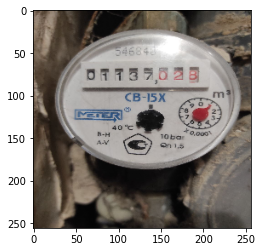

In [ ]:
img = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256, 256)) / 255.
plt.imshow(img)
img_to_pred=np.expand_dims(img,axis=0)

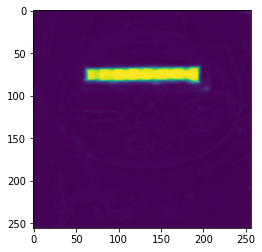

In [ ]:
model = tf.keras.models.load_model(segmentation_model_file, custom_objects={'FocalLoss': FocalLoss, 'dice_coef' : dice_coef})
pred = model.predict(img_to_pred)
pred_to_show = pred.squeeze()
plt.imshow(pred_to_show)

## OCR part

In [ ]:
def crop(img, bg, mask) -> np.array:
    '''
    Function takes image, background, and mask, and crops the image.
    The cropped image should correspond only with the positive portion of the mask.
    '''
    fg = cv2.bitwise_or(img, img, mask=mask) 
    fg_back_inv = cv2.bitwise_or(bg, bg, mask=cv2.bitwise_not(mask))
    New_image = cv2.bitwise_or(fg, fg_back_inv)
    return New_image

True

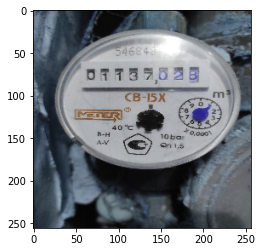

In [ ]:
mask = pred_to_show
mask[mask>0.5]=1
img = cv2.imread('/content/one_img_test/one_img_test/Water counter.jpg')
img = cv2.resize(img, (256, 256))
mask = mask.astype('uint8')
    
h, w, _ = img.shape

bg = np.zeros_like(img, 'uint8') # Black background

New_image = crop(img,bg,mask)
New_image = cv2.cvtColor(New_image, cv2.COLOR_BGR2RGB)


where = np.array(np.where(New_image))
x1, y1, z1 = np.amin(where, axis=1)
x2, y2, z2 = np.amax(where, axis=1)
sub_image = New_image.astype('uint8')[x1:x2, y1:y2]


cv2.imwrite('new_img.jpg', sub_image)

In [ ]:
def resize_aspect_fit(img, final_size: int):
    '''
    Function resizes the image to specified size.
    
    path - The path to the directory with images.
    final_size - The size you want the final images to be. Should be in int (will be used for w and h).
    write_to - The file you wish to write the images to. 
    save - Whether to save the files (True) or return them.
    '''   
    im_pil = Image.fromarray(img)
    size = im_pil.size
    ratio = float(final_size) / max(size)
    new_image_size = tuple([int(x*ratio) for x in size])
    im_pil = im_pil.resize(new_image_size, Image.ANTIALIAS)
    new_im = Image.new("RGB", (final_size, final_size))
    new_im.paste(im_pil, ((final_size-new_image_size[0])//2, (final_size-new_image_size[1])//2))
    new_im = np.asarray(new_im)
    return np.array(new_im)

def prep_for_ocr(img):
    img = resize_aspect_fit(img, 224)
    output_name = 'test_img_for_ocr.jpg'
    cv2.imwrite(output_name, img)
    return output_name

In [ ]:
def get_reading(image_path):
 
    #Prep image and save path.
    prepped_path = prep_for_ocr(image_path)
        
    #Class labels.
    labels = ['number', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    
    #List for storing meter readings.
    list_of_img_reading = []
    
    #Configure model parameters.
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
    cfg.MODEL.WEIGHTS = '/content/one_img_test/one_img_test/model_final.pth'
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6
    cfg.MODEL.DEVICE='cpu'
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 11
    predictor = DefaultPredictor(cfg)

    #Read prepped image and obtain prediction.
    im = cv2.imread(prepped_path)
    outputs = predictor(im)
    
    #Find predicted boxes and labels.
    instances = outputs['instances']
    coordinates = outputs['instances'].pred_boxes.tensor.cpu().numpy()
    pred_classes = outputs['instances'].pred_classes.cpu().tolist()
    
    #Obtain list of all predictions and the leftmost x-coordinate for bounding box.
    pred_list = []
    for pred, coord in zip(pred_classes, coordinates):
        pred_list.append((pred, coord[0]))
    
    #Sort the list based on x-coordinate in order to get proper order or meter reading.
    pred_list = sorted(pred_list, key=lambda x: x[1])
    
    #Get final order of identified classes, and map them to class value.
    final_predictions = [x[0] for x in pred_list]
    pred_class_names = list(map(lambda x: labels[x], final_predictions))
    
    #Add decimal point to list of digits depending on number of bounding boxes.
    if len(pred_class_names) == 5:
        pass
    else:
        pred_class_names.insert(5, '.')
        
    #Combine digits and convert them into a float.
    combine_for_float = "".join(pred_class_names)
    meter_reading = float(combine_for_float)
    
    return meter_reading
    #return combine_for_float

In [ ]:
print(f'Meter reading: {get_reading(sub_image)}')

Meter reading: 1137.075


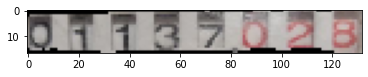

In [ ]:
plt.imshow(sub_image)